# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum, isnan, to_date, to_timestamp, from_unixtime, count
from pyspark.sql.window import Window


import pyspark.sql.functions as F
from pyspark.sql.functions import col, count_distinct, countDistinct

from pyspark.sql.types import LongType, TimestampType
from pyspark.sql.functions import substring, from_unixtime

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df_original = df

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Easier visual exploration as Pandas data frame
df.limit(5).toPandas()

# Questions to explore:
# sessionId unique across users? (can two users have the same sessionId?)
# what is the column "method"

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
# Do some users switch between subscription levels? > yes
df.groupby("userId").agg(F.count_distinct("level")).show(5)

+------+---------------------+
|userId|count(DISTINCT level)|
+------+---------------------+
|100010|                    1|
|200002|                    2|
|   125|                    1|
|     7|                    1|
|   124|                    1|
+------+---------------------+
only showing top 5 rows



#### Extract State from Location

In [7]:
# Which locations are contained in the data set?
print(f"{df.select('location').distinct().count()} unique locations.")

df.select("location").distinct().show(5)

# --> Only locations within the USA are contained

115 unique locations.
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Kingsport-Bristol...|
|New Haven-Milford...|
|         Dubuque, IA|
+--------------------+
only showing top 5 rows



In [8]:
# Extract state with regex

# https://stackoverflow.com/questions/4419000/regex-match-everything-after-question-mark
df = df.withColumn("state", F.regexp_extract(df.location, "\, (.*)", 1))
df.show(5)

# Are there users who used the service from multiple states? --> no
df.groupBy("userId").agg(F.count_distinct("state").alias("distinct_state")).sort("distinct_state", ascending=False).show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|   CA|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|

#### Extract Device

In [9]:
print(f'Distinct user agents: {df.select("userAgent").distinct().count()}') # there are 57 distinct user agents (OS & browser combinations)

df.select("userAgent").distinct().show(5)

Distinct user agents: 57
+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
+--------------------+
only showing top 5 rows



In [10]:
# Keywords to group by (manual analysis of the distinct user agents): Windows, Macintosh, iPhone, Linux, iPad

# Create dummy variables for these groups with text search

# https://stackoverflow.com/questions/40161879/pyspark-withcolumn-with-two-conditions-and-three-outcomes
device_detailed =   F.when(F.locate("Windows", df.userAgent) > 0, "Windows")\
                        .otherwise(F.when(F.locate("Macintosh", df.userAgent) > 0, "MacIntosh")\
                        .otherwise(F.when(F.locate("iPhone", df.userAgent) > 0, "iPhone")\
                        .otherwise(F.when(F.locate("Linux", df.userAgent) > 0, "Linux")\
                        .otherwise(F.when(F.locate("iPad", df.userAgent) > 0, "iPad")
                        .otherwise("other")
                    ))))


device_group =   F.when(F.locate("Windows", df.userAgent) > 0, "Windows")\
                    .otherwise(F.when(
                                        (F.locate("Macintosh", df.userAgent) > 0) | 
                                        (F.locate("iPhone", df.userAgent) > 0) | 
                                        (F.locate("iPad", df.userAgent) > 0), "Apple")\
                    .otherwise(F.when(F.locate("Linux", df.userAgent) > 0, "Linux")\
                    .otherwise("other")))
                

df = df.withColumn("deviceGroup", device_group)
df = df.withColumn("deviceGroupDetailed", device_detailed)


# To be tested whether the more detailed grouping makes sense since iPad & iPhone represent a small percentage
df.groupBy("deviceGroupDetailed").count().show()

df.groupBy("deviceGroup").count().show()

+-------------------+------+
|deviceGroupDetailed| count|
+-------------------+------+
|               iPad| 11381|
|             iPhone| 11192|
|              Linux|  8961|
|              other|  8346|
|          MacIntosh|102749|
|            Windows|143871|
+-------------------+------+

+-----------+------+
|deviceGroup| count|
+-----------+------+
|      Linux|  8961|
|      other|  8346|
|      Apple|125322|
|    Windows|143871|
+-----------+------+



In [11]:
# Do users use multiple devices to access the service? --> no

df.groupBy("userId").agg(F.count_distinct("deviceGroup").alias("unique_devices")).sort("unique_devices", ascending=False).show(5)

+------+--------------+
|userId|unique_devices|
+------+--------------+
|100010|             1|
|200002|             1|
|   125|             1|
|    51|             1|
|     7|             1|
+------+--------------+
only showing top 5 rows



### Add other columns based on visited pages (e.g. Error, Thumbs Down, Help)

In [12]:
# Which pages do users interact with the most?
df.groupBy("page").count().sort("count", ascending=False).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [13]:
# Distinct values per column
# https://stackoverflow.com/questions/40888946/spark-dataframe-count-distinct-values-of-every-column

distinct_value_count = df.agg(*(F.countDistinct(F.col(c)).alias(c) for c in df.columns)).show()
distinct_value_count

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+-----+-----------+-------------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|    ts|userAgent|userId|state|deviceGroup|deviceGroupDetailed|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+-----+-----------+-------------------+
| 17655|   4|      189|     2|         1322|     173| 14865|    2|     114|     2|  22|         225|     2354|58480|     3|277447|       56|   226|   58|          4|                  6|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+-----+-----------+-------------------+



## Cleanup & Prep of Timestamp and Date

In [14]:
# Check for null values in the timestamp column
# https://stackoverflow.com/questions/48229043/python-pyspark-count-null-empty-and-nan
df.filter((df["ts"] == "") | df["ts"].isNull() | isnan(df["ts"])).count()

0

In [15]:
# Remove milliseconds (last 3 digits) from ts to enable conversion to datetime
df = df.withColumn("ts_no_ms", substring(df.ts, 0, 10))
# df = df.withColumn("ts_no_ms", df.ts_no_ms.cast(TimestampType()))
# df = df.withColumn("ts_unix", from_unixtime(df.ts))
df = df.withColumn("ts_str", F.from_unixtime(df.ts_no_ms))
df = df.withColumn("ts_date", F.to_date(F.from_unixtime(df.ts_no_ms)))


df = df.withColumn("ts_tsType", df.ts_str.cast(TimestampType()))

df = df.withColumn("weekday", F.weekday(df.ts_tsType))
df = df.withColumn("day_of_week", F.dayofweek(df.ts_tsType))
df = df.withColumn("day", F.date_format(df.ts_tsType, "E"))
df = df.withColumn("hour", F.hour(df.ts_tsType))
df = df.withColumn("year", F.year(df.ts_tsType))
df = df.withColumn("weekNum", F.weekofyear(df.ts_tsType))

# df.printSchema()
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+

In [16]:
# Format registration date and days since registration per user
df = df.withColumn("registration_date", F.to_date(F.from_unixtime(substring(df.registration, 0, 10))))

# How to efficiently find the last date / ts when each user used the service?
window = Window.partitionBy(["userId"])
df = df.withColumn("last_visited_date", F.max(col("ts_date")).over(window))

df = df.withColumn("days_since_registration", F.date_diff(col("last_visited_date"), col("registration_date")))

df.show(5)


### Code to verify correct calculation of days_since_registration:
# df.where(df.userId == 132).show()
# df.groupBy("userId").agg(F.max("registration_date"), F.max("ts_date")).show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+-

## Visualizations on Sparkify usage

Songs played per hour of the day

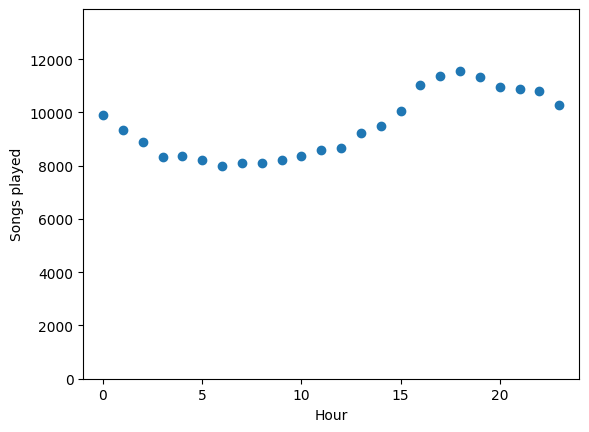

In [17]:
songs_in_hour = df.filter(df.page == "NextSong").groupby("hour").count().sort("hour").toPandas()

plt.scatter(songs_in_hour["hour"], songs_in_hour["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [18]:
def groupby_plot(df, x_col:str, page_filter:str, x_label:str, y_label:str):
    """Aggregate data and create scatterplot to visualize trends in the data."""
    # df_grouped = df.groupby(x_col).count().sort(x_col).toPandas()
    df_grouped = df.filter(df.page == page_filter).groupby(x_col).count().sort(x_col).toPandas()
    plt.scatter(df_grouped[x_col], df_grouped["count"])
    plt.xlim(-1, max(df_grouped[x_col])+1);
    plt.ylim(0, 1.2 * max(df_grouped["count"]))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show
    return None

In [19]:
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.agg(*(F.countDistinct(col(c)).alias(c) for c in df.columns)).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts_tsType,weekday,day_of_week,day,hour,year,weekNum,registration_date,last_visited_date,days_since_registration
0,17655,4,189,2,1322,173,14865,2,114,2,...,277447,7,7,7,24,1,10,87,49,110


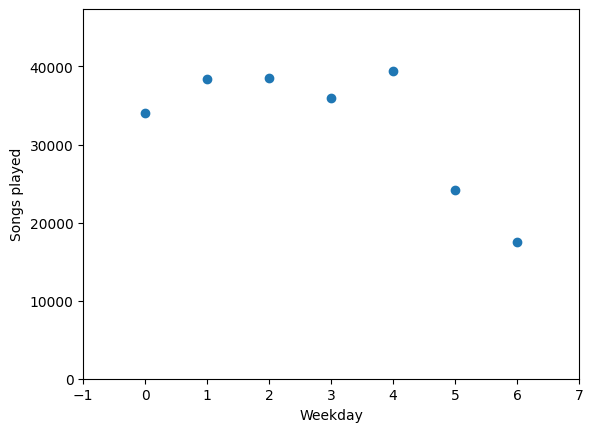

In [20]:
# groupby_plot(df, "hour", "NextSong", "Hour", "Songs played")

# groupby_plot(df, "hour", "Home", "Hour", "Songs played")

groupby_plot(df, "weekday", "NextSong", "Weekday", "Songs played")

## Analysis and handling of null values

In [21]:
# https://stackoverflow.com/questions/64147246/pyspark-need-to-show-a-count-of-null-empty-values-per-each-column-in-a-datafram
df.select(*(count(F.when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+-----------+-------------------+--------+------+-------+---------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|state|deviceGroup|deviceGroupDetailed|ts_no_ms|ts_str|ts_date|ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+-----------+-------------------+--------+------+-------+---------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
| 58392|   0|     8346|  8346|            0

In [22]:
# df.filter(df.gender.isNull()).show()

df.filter(df.auth == "Cancelled").show(5)

df.filter(df.auth == "Guest").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|   state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+-

In [23]:
df.groupBy("gender").count().show()

df.groupBy("auth").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  NULL|  8346|
|     M|123576|
+------+------+

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Logged In|278102|
| Cancelled|    52|
|     Guest|    97|
+----------+------+



In [24]:
# Number of subscription cancellations (churn)
# df.where(df.page=="Cancellation Confirmation").agg(count("userID")).collect()

# df.where(df.page=="Cancellation Confirmation").show()

# See which pages can be visited as a logged in user / guest
df.groupBy(["auth", "page"]).count().sort("auth").show(100)

+----------+--------------------+------+
|      auth|                page| count|
+----------+--------------------+------+
| Cancelled|Cancellation Conf...|    52|
|     Guest|            Register|    18|
|     Guest|               About|    14|
|     Guest|               Error|     1|
|     Guest| Submit Registration|     5|
|     Guest|                Help|    23|
|     Guest|                Home|    36|
| Logged In|              Logout|  3226|
| Logged In|           Thumbs Up| 12551|
| Logged In|         Roll Advert|  3933|
| Logged In|      Submit Upgrade|   159|
| Logged In|            Settings|  1514|
| Logged In|         Thumbs Down|  2546|
| Logged In|       Save Settings|   310|
| Logged In|                Help|  1454|
| Logged In|            NextSong|228108|
| Logged In|               About|   495|
| Logged In|     Add to Playlist|  6526|
| Logged In|               Error|   252|
| Logged In|                Home| 10082|
| Logged In|          Add Friend|  4277|
| Logged In|    

In [25]:
# Keep only logged in users & cancellations in the data set
df = df.filter((df.auth == "Logged In") | (df.auth == "Cancelled"))

In [26]:
# Remove cancellation confirmation from df that will be pivoted for feature engineering
df_pages_share = df.filter((df.auth == "Logged In") & (df.page != "Cancel"))

df_pages_share = df_pages_share.groupBy(["userId", "page"]).count().sort(["userId", "page"])
df_pages_share = df_pages_share.withColumnRenamed("count", "page_visits")
# df_pages_share = df_pages_share.where("")


window = Window.partitionBy(["userId"])

df_pages_share = df_pages_share.withColumn("sum_page_visits", F.sum(col("page_visits")).over(window))
df_pages_share = df_pages_share.withColumn("share_page_visits", (df_pages_share.page_visits / F.sum(col("page_visits")).over(window)))


df_pages_share.show()

+------+---------------+-----------+---------------+--------------------+
|userId|           page|page_visits|sum_page_visits|   share_page_visits|
+------+---------------+-----------+---------------+--------------------+
|    10|          About|          2|            795|0.002515723270440...|
|    10|     Add Friend|         12|            795| 0.01509433962264151|
|    10|Add to Playlist|          9|            795|0.011320754716981131|
|    10|      Downgrade|          7|            795| 0.00880503144654088|
|    10|           Help|          1|            795|0.001257861635220...|
|    10|           Home|         30|            795| 0.03773584905660377|
|    10|         Logout|         11|            795|0.013836477987421384|
|    10|       NextSong|        673|            795|  0.8465408805031447|
|    10|    Roll Advert|          1|            795|0.001257861635220...|
|    10|  Save Settings|          1|            795|0.001257861635220...|
|    10|       Settings|          7|  

In [27]:
join_df_pages_share = df_pages_share.groupBy("userId").pivot("page").max("share_page_visits").fillna(0)
join_df_pages_share.show()

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settings|            Settings|    Submit Downgrade|      Submit Upgrade|         Thumbs Down|           Thumbs Up|             Upgrade|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [28]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- state: string (nullable = true)
 |-- deviceGroup: string (nullable = false)
 |-- deviceGroupDetailed: string (nullable = false)
 |-- ts_no_ms: string (nullable = true)
 |-- ts_str: string (nullable = true)
 |-- ts_date: date (nullable = true)
 |-- ts_tsType: timestamp (nullable = true)
 |-- weekday: 

In [29]:
# Number of unique users in this subset of data
df.agg(countDistinct("userID")).collect()[0][0]

225

In [30]:
# Are all of these unique cancellations or did some users resubscribe and cancel again?
df.where(df.page=="Cancellation Confirmation").groupBy("userId").count().sort("count", ascending=False).head(10)
# > No, all cancellations are from unique users

[Row(userId='18', count=1),
 Row(userId='32', count=1),
 Row(userId='125', count=1),
 Row(userId='51', count=1),
 Row(userId='101', count=1),
 Row(userId='17', count=1),
 Row(userId='143', count=1),
 Row(userId='105', count=1),
 Row(userId='121', count=1),
 Row(userId='129', count=1)]

### Add churn flag

In [31]:
df = df.withColumn("churnFlag", F.when(df.page=="Cancellation Confirmation", 1).otherwise(0))
df.where(df.churnFlag==1).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+--------+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|   state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--

### Create column that flags all churned users for each interaction

In [32]:
# window_userId = Window.partitionBy("userId").orderBy("ts")

# df = df.withColumn("window_test", count("userId").over(window_userId))
# df.show()

In [33]:
df.createOrReplaceTempView("user_logs")

# Issue, the distinct userId also selects rows where the flag is not present

df_sql = spark.sql('''
    SELECT *, IF(flag = 1, 1, 0) AS userChurned
    FROM user_logs
    LEFT JOIN (
        SELECT DISTINCT userId AS uid, 1 AS flag
        FROM user_logs
        WHERE churnFlag = 1
        ) AS churned_users
    ON user_logs.userId = churned_users.uid
    '''
)

df_sql = df_sql.drop(*["uid", "flag"])

df_sql.show()

df = df_sql

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+---------------

In [34]:
df_sql.filter((df_sql.userChurned == 1) & (df_sql.page != "Cancellation Confirmation")).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------

#### sessionId Analysis
Could the sessionId be a useful feature? --> No

In [35]:
# Count per distinct sessionId
df.groupBy("sessionId").count().sort("sessionId").show()

# Count per distinct sessionId & userId
df.groupBy("sessionId", "userId").count().sort("sessionId").show()

# --> Seems to have no meaningful logic since not all users have data for session 1 - x

+---------+-----+
|sessionId|count|
+---------+-----+
|        1|  680|
|        2|    7|
|        3|   37|
|        4|   24|
|        5|   57|
|        6|   68|
|        7|    1|
|        8|   45|
|        9|  190|
|       10|  165|
|       11|   46|
|       12|   59|
|       13|  119|
|       15|  213|
|       16|   39|
|       17|  169|
|       18|   27|
|       19|  151|
|       20|   29|
|       21|  127|
+---------+-----+
only showing top 20 rows

+---------+------+-----+
|sessionId|userId|count|
+---------+------+-----+
|        1|     2|  428|
|        1|100001|   51|
|        1|300001|  201|
|        2|200002|    7|
|        3|100003|    2|
|        3|300003|   35|
|        4|100004|   24|
|        5|     6|    5|
|        5|100005|   52|
|        6|100006|   44|
|        6|300006|   24|
|        7|200007|    1|
|        8|     9|   45|
|        9|    10|   70|
|        9|100009|   28|
|        9|300009|   92|
|       10|200010|   86|
|       10|    11|    9|
|       10|300010

### Compare characteristics of both groups (churned & active users)

In [36]:
df.groupBy(["userChurned"]).count().sort("userChurned").show(100)

# df.groupBy(["userChurned", "page"]).count().sort("userChurned").show(100)

+-----------+------+
|userChurned| count|
+-----------+------+
|          0|233290|
|          1| 44864|
+-----------+------+



##### Usage statistics by churned / active

In [37]:
df.groupBy(["userChurned"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                F.max("userChurned").alias("userChurned"),
                                                F.mean("length").alias("avg_length"), 
                                                F.sum("length").alias("sum_length"),
                                                F.count("length").alias("played_songs"),
                                                (F.count("length").alias("played_songs") / F.count_distinct("userId")).alias("avg_songs_played")
                                                ).show()

+-----------+----------+-----------+------------------+--------------------+------------+------------------+
|userChurned|user_count|userChurned|        avg_length|          sum_length|played_songs|  avg_songs_played|
+-----------+----------+-----------+------------------+--------------------+------------+------------------+
|          1|        52|          1|248.63279564406227|   9048741.964670002|       36394| 699.8846153846154|
|          0|       173|          0| 249.2091353888082|4.7776880181929976E7|      191714|1108.1734104046243|
+-----------+----------+-----------+------------------+--------------------+------------+------------------+



##### Usage statistics by churned / active and week

In [38]:
df.groupBy(["userChurned", "weekNum"]).agg(
                                                F.count_distinct("userId").alias("user_count"),
                                                F.max("userChurned").alias("userChurned"),
                                                F.mean("length").alias("avg_length"), 
                                                F.sum("length").alias("sum_length"),
                                                F.count("length").alias("played_songs"),
                                                (F.count("length").alias("played_songs") / F.count_distinct("userId")).alias("avg_songs_played")
                                                ).sort(["weekNum", "userChurned"]).show()

+-----------+-------+----------+-----------+------------------+------------------+------------+------------------+
|userChurned|weekNum|user_count|userChurned|        avg_length|        sum_length|played_songs|  avg_songs_played|
+-----------+-------+----------+-----------+------------------+------------------+------------+------------------+
|          0|     40|       116|          0|249.07581465804785|     3853202.85276|       15470|133.36206896551724|
|          1|     40|        46|          1|251.29148589659124|     1754517.15453|        6982| 151.7826086956522|
|          0|     41|       117|          0| 249.0836966144075|     4353235.76573|       17477| 149.3760683760684|
|          1|     41|        41|          1|246.75710027618663|2412297.4123000004|        9776| 238.4390243902439|
|          0|     42|       122|          0|249.09202399431004| 5515893.779330001|       22144|181.50819672131146|
|          1|     42|        34|          1|248.63771257003478|1783975.587689999

In [39]:
# How to flg actions before churn per user?
# Groupby / window by user and flag where the timestamp is before the churnFlag
# df = df.withColumn("beforeChurn")



## Aggregations on user level

In [40]:
df.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+

In [41]:
df_agg_user = df.groupBy(["userId"]).agg(
                                            F.max("userChurned").alias("userChurned"),
                                            F.max("gender").alias("gender"),
                                            F.max("level").alias("level"),
                                            F.mean("length").alias("avg_length"), 
                                            F.sum("length").alias("sum_length"),
                                            F.count("length").alias("played_songs"),
                                            F.max("state").alias("state"),
                                            F.max("deviceGroup").alias("deviceGroup"),
                                            F.max("days_since_registration").alias("days_since_registration")
                                        )


df_agg_user.show()

+------+-----------+------+-----+------------------+------------------+------------+--------+-----------+-----------------------+
|userId|userChurned|gender|level|        avg_length|        sum_length|played_songs|   state|deviceGroup|days_since_registration|
+------+-----------+------+-----+------------------+------------------+------------+--------+-----------+-----------------------+
|   100|          0|     M| paid|250.88659828113387|  672877.856590001|        2682|      TX|    Windows|                     65|
|100005|          1|     M| free|240.50079227272732| 37037.12201000001|         154|      LA|      Apple|                     85|
|100006|          1|     F| free|225.18811730769232|        5854.89105|          26|      MI|    Windows|                      9|
|100008|          0|     F| paid|247.92331090673568|191396.79601999995|         772|      CA|      Apple|                     68|
|100010|          0|     F| free|  243.421444909091| 66940.89735000003|         275|      

## Aggregations on user & week level

In [42]:
# df_agg = df.groupBy(["userId", "weekNum"]).agg({"length":"mean", "length":"sum", "length":"count"})

df_agg = df.groupBy(["userId", "weekNum"]).agg(
                                                F.max("userChurned").alias("userChurned"),
                                                F.mean("length").alias("avg_length"), 
                                                F.sum("length").alias("sum_length"),
                                                F.count("length").alias("played_songs")
                                                
                                                )


df_agg.where(df_agg.userId == 143).show()

window = Window.partitionBy(["userId"]).orderBy(["userId", "weekNum"])

# df_agg.withColumn("delta_playtime_wow", F.lag("sum_length", default=0).over(window)).show()

df_agg = df_agg.withColumn("delta_playtime_wow", (df_agg.sum_length / F.lag("sum_length", default=0).over(window)))

df_agg = df_agg.withColumn("delta_songs_played_wow", (df_agg.played_songs / F.lag("played_songs", default=0).over(window)))


df_agg.show()


+------+-------+-----------+------------------+------------------+------------+
|userId|weekNum|userChurned|        avg_length|        sum_length|played_songs|
+------+-------+-----------+------------------+------------------+------------+
|   143|     40|          1|247.14041907692314|16064.127240000003|          65|
|   143|     41|          1|237.30048294117643|4034.1082099999994|          17|
|   143|     42|          1|262.78725894736846| 4992.957920000001|          19|
+------+-------+-----------+------------------+------------------+------------+

+------+-------+-----------+------------------+------------------+------------+-------------------+----------------------+
|userId|weekNum|userChurned|        avg_length|        sum_length|played_songs| delta_playtime_wow|delta_songs_played_wow|
+------+-------+-----------+------------------+------------------+------------+-------------------+----------------------+
|   100|     40|          0| 244.2558602362204|62040.988499999985|    

#### Create tables with WoW changes in played songs / playtime per user

In [43]:
weeks_list = ["41", "42", "43", "44", "45", "46", "47", "48"]

##### WoW Playtime

In [44]:
wow_playtime_colnames = ["userId"] + [x + "_wow_pt_change" for x in weeks_list]

join_df_wow_playtime = df_agg.groupBy("userId").pivot("weekNum").max("delta_playtime_wow").fillna(0)

# Drop first and last week in dataset since no changes are present
join_df_wow_playtime = join_df_wow_playtime.drop("40", "49")
join_df_wow_playtime = join_df_wow_playtime.toDF(*wow_playtime_colnames)

join_df_wow_playtime.show(5)

+------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+
|userId|  41_wow_pt_change|   42_wow_pt_change|   43_wow_pt_change|  44_wow_pt_change|   45_wow_pt_change|   46_wow_pt_change|  47_wow_pt_change|   48_wow_pt_change|
+------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+
|   100|1.0391434266073956|  0.771417668170628|  2.042258737910301|1.2618010511778168|0.32610260221270276| 1.9445783374712677|0.9798185823454033| 0.8064724578674192|
|100005|               0.0|  0.912211317132697|                0.0|               0.0|                0.0|                0.0|               0.0|                0.0|
|100006|               0.0|                0.0|                0.0|               0.0|                0.0|                0.0|               0.0|                0.0|
|100

##### WoW Played Songs

In [45]:
wow_played_songs_colnames = ["userId"] + [x + "_wow_songs_change" for x in weeks_list]

join_df_wow_played_songs = df_agg.groupBy("userId").pivot("weekNum").max("delta_songs_played_wow").fillna(0)

# Drop first and last week in dataset since no changes are present
join_df_wow_played_songs = join_df_wow_played_songs.drop("40", "49")
join_df_wow_played_songs = join_df_wow_played_songs.toDF(*wow_played_songs_colnames)

join_df_wow_played_songs.show(5)

+------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|userId|41_wow_songs_change|42_wow_songs_change|43_wow_songs_change|44_wow_songs_change|45_wow_songs_change|46_wow_songs_change|47_wow_songs_change|48_wow_songs_change|
+------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|   100| 1.0236220472440944| 0.7576923076923077|  2.065989847715736| 1.2481572481572483|  0.328740157480315| 1.8922155688622755| 1.0031645569620253|  0.807570977917981|
|100005|                0.0| 0.8333333333333334|                0.0|                0.0|                0.0|                0.0|                0.0|                0.0|
|100006|                0.0|                0.0|                0.0|                0.0|                0.0|                0.0|                0.0|       

In [46]:
# df_agg.groupBy(["userId", "weekNum"]).agg({"length":"mean"}).show()

# df_agg.groupBy("weekNum").agg(F.avg("length")).sort("weekNum").show()

# df_agg.groupBy("weekNum", "userChurned").agg(F.avg("length")).sort("weekNum", "userChurned").show()

In [47]:
df_agg.head()

Row(userId='100', weekNum=40, userChurned=0, avg_length=244.2558602362204, sum_length=62040.988499999985, played_songs=254, delta_playtime_wow=None, delta_songs_played_wow=None)

In [48]:
# window = Window.partitionBy("weekNum").orderBy("weekNum")

# df_window = df.withColumn("TEST", F.avg("length").over(window))

# df_window.where(df_window.weekNum == 48).show()

### Join DFs on User Level

In [49]:
df_agg_user.show(5)

+------+-----------+------+-----+------------------+------------------+------------+-----+-----------+-----------------------+
|userId|userChurned|gender|level|        avg_length|        sum_length|played_songs|state|deviceGroup|days_since_registration|
+------+-----------+------+-----+------------------+------------------+------------+-----+-----------+-----------------------+
|   100|          0|     M| paid|250.88659828113387|  672877.856590001|        2682|   TX|    Windows|                     65|
|100005|          1|     M| free|240.50079227272732| 37037.12201000001|         154|   LA|      Apple|                     85|
|100006|          1|     F| free|225.18811730769232|        5854.89105|          26|   MI|    Windows|                      9|
|100008|          0|     F| paid|247.92331090673568|191396.79601999995|         772|   CA|      Apple|                     68|
|100010|          0|     F| free|  243.421444909091| 66940.89735000003|         275|   CT|      Apple|         

In [50]:
join_df_pages_share.show(5)
join_df_wow_played_songs.show(5)

+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|userId|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Settings|            Settings|    Submit Downgrade|      Submit Upgrade|         Thumbs Down|           Thumbs Up|             Upgrade|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------

In [51]:
# Avoid duplicate column names by using a list inside the join function
# https://stackoverflow.com/questions/46944493/removing-duplicate-columns-after-a-df-join-in-spark

df_joined = df_agg_user.join(join_df_pages_share, ["userId"], "left")
df_joined = df_joined.join(join_df_wow_played_songs, ["userId"],  "left")

df_joined.show()

+------+-----------+------+-----+------------------+------------------+------------+--------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+
|userId|userChurned|gender|level|        avg_length|        sum_length|played_songs|   state|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|       Save Sett

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [52]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline


In [53]:
df_joined.show(3)

+------+-----------+------+-----+------------------+-----------------+------------+--------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+
|userId|userChurned|gender|level|        avg_length|       sum_length|played_songs|   state|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|Save Settings|            Settings|Subm

##### Prepare lists for easier automation of pipeline

In [54]:
# cols_for_transformation = ["state", "gender", "deviceGroup", "level"]
cols_for_transformation = ["deviceGroup", "level"]

indexed_cols = [x + "_index" for x in cols_for_transformation]
vectorized_cols = [x + "_vec" for x in cols_for_transformation]

vectorized_cols

['deviceGroup_vec', 'level_vec']

##### Index categorical variables

In [55]:
str_indexer = StringIndexer(inputCols=cols_for_transformation, outputCols=indexed_cols)
model = str_indexer.fit(df_joined)
df_transformed = model.transform(df_joined)

df_transformed = df_transformed.drop("gender").drop("state")

df_transformed.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|Save Settings|            Settings|Submit

##### Use One Hot Encoder for Indexed Variables

In [56]:
ohe = OneHotEncoder(inputCols=indexed_cols, outputCols=vectorized_cols)
model_ohe = ohe.fit(df_transformed)
df_transformed = model_ohe.transform(df_transformed)

df_transformed.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|          Downgrade|               Error|                Help|                Home|              Logout|          NextSong|         Roll Advert|Save Settin

In [57]:
cols_for_vecAssembler = set(df_transformed.columns) - set(cols_for_transformation)
cols_for_vecAssembler.remove("userId")
cols_for_vecAssembler.remove("userChurned")

cols_for_vecAssembler = list(cols_for_vecAssembler)

In [58]:
vec_assembler = VectorAssembler(inputCols=cols_for_vecAssembler, outputCol="features")
df_transformed = vec_assembler.transform(df_transformed)
# df_transformed.groupby(["page", "page_numeric"]).count().sort("page_numeric").toPandas()

df_transformed.show(5)

+------+-----------+-----+------------------+------------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+--------------------+
|userId|userChurned|level|        avg_length|        sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|        

### OLD Features

In [59]:
# # String indexer for visited page
# str_indexer = StringIndexer(inputCol="page", outputCol="page_numeric")

# model = str_indexer.fit(df)

# df_transformed = model.transform(df)

# str_ohe = OneHotEncoder(inputCol="page_numeric", outputCol="page_vec")
# model2 = str_ohe.fit(df_transformed)
# df_transformed = model2.transform(df_transformed)

# # df_transformed.groupby(["page", "page_numeric"]).count().sort("page_numeric").toPandas()

# df_transformed.show()

In [60]:
# # The approach of indexing and transforming several columns at once was taken from here: 
# # https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe

# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["page"]]

# pipeline = Pipeline(stages=indexers)

# df_transformed = pipeline.fit(df).transform(df)

# df_transformed.head()

In [61]:
# # Test same approach as above for multiple columns and then indexing + vectorizing
# indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["page", "gender"]]

# # vectorizers = [OneHotEncoder(inputCol=column, outputCol=column+"_ohe").fit(df) for column in ["page_index", "gender_index"]]


# pipeline = Pipeline(stages=indexers)

# df_transformed = pipeline.fit(df).transform(df)

# df_transformed.show()

In [62]:
# cols_for_transformation = ["page", "gender"]
# indexed_cols = [x + "_index" for x in cols_for_transformation]
# vectorized_cols = [x + "_vec" for x in cols_for_transformation]

# vectorized_cols

In [63]:
# # Test other approach with new argument input_cols / output_cols
# str_indexer = StringIndexer(inputCols=cols_for_transformation, outputCols=indexed_cols)
# model = str_indexer.fit(df)
# df_transformed = model.transform(df)

# ohe = OneHotEncoder(inputCols=indexed_cols, outputCols=vectorized_cols)
# model2 = ohe.fit(df_transformed)
# df_transformed = model2.transform(df_transformed)

# vec_assembler = VectorAssembler(inputCols=vectorized_cols, outputCol="features")
# df_transformed = vec_assembler.transform(df_transformed)
# # df_transformed.groupby(["page", "page_numeric"]).count().sort("page_numeric").toPandas()

# df_transformed.show()

### Aggregate Data on User Level for Modeling

In [64]:
df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+-------------------+----------+-------------------+----------+-------------------+-------+-----------+---+----+----+-------+-----------------+-----------------+-----------------------+---------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|state|deviceGroup|deviceGroupDetailed|  ts_no_ms|             ts_str|   ts_date|          ts_tsType|weekday|day_of_week|day|hour|year|weekNum|registration_date|last_visited_date|days_since_registration|churnFlag|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+---------------

### Aggregate data on user & weekly level (OLD)

In [65]:
df_agg.show()

+------+-------+-----------+------------------+------------------+------------+-------------------+----------------------+
|userId|weekNum|userChurned|        avg_length|        sum_length|played_songs| delta_playtime_wow|delta_songs_played_wow|
+------+-------+-----------+------------------+------------------+------------+-------------------+----------------------+
|   100|     40|          0| 244.2558602362204|62040.988499999985|         254|               NULL|                  NULL|
|   100|     41|          0| 247.9595591538462|64469.485380000006|         260| 1.0391434266073956|    1.0236220472440944|
|   100|     42|          0|252.45126944162433| 49732.90007999999|         197|  0.771417668170628|    0.7576923076923077|
|   100|     43|          0|249.55147358722337|101567.44974999991|         407|  2.042258737910301|     2.065989847715736|
|   100|     44|          0|252.27935996062988|128157.91485999998|         508| 1.2618010511778168|    1.2481572481572483|
|   100|     45|

In [66]:
# # df_transformed = df_agg.withColumnRenamed("delta_songs_played_wow", "features")
# df_transformed = df_agg.where(col("delta_songs_played_wow").isNotNull())

# vec_assembler = VectorAssembler(inputCols=["delta_songs_played_wow"], outputCol="features")
# df_transformed = vec_assembler.transform(df_transformed)

### Modeling

#### Handling of imbalanced data

Since we have an imbalanced data set (23% of users churned), adding a weight column for modeling is appropriate.

https://stackoverflow.com/questions/69464059/how-to-assign-class-weights-for-a-logistic-regression-model-in-apache-sparks-ml

In [67]:
df.groupBy(["userChurned"]).agg(F.count_distinct("userId").alias("user_count")).show()

print(f"Share of churned users: {52/(173+52)}")

df_transformed = df_transformed.withColumn("class_weight", F.when(df_transformed.userChurned == 1, 0.77).otherwise(0.23))
df_transformed.show(3)

+-----------+----------+
|userChurned|user_count|
+-----------+----------+
|          1|        52|
|          0|       173|
+-----------+----------+

Share of churned users: 0.2311111111111111
+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+--------------------+----------------+--------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+--------------------+------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_reg

### Logistic Regression

In [68]:
lr = LogisticRegression(featuresCol="features", labelCol="userChurned", weightCol="class_weight")

In [69]:
# https://www.geeksforgeeks.org/logistic-regression-using-pyspark-python/

# Split dataset into training and test
df_train, df_test = df_transformed.randomSplit([0.8, 0.2], seed=42)

model = lr.fit(df_train)

predictions = model.transform(df_test)

df_train.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+--------------------+------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout| 

In [70]:
predictions.show(3)

+------+-----------+-----+------------------+------------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+--------------------+------------+--------------------+--------------------+----------+
|userId|userChurned|level|        avg_length|        sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|            

Which metrics should be used for evaluation?

The F-Score is best in this case since the data set is imbalanced. Only about 20% of users have churned. 
See https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#binary-classification 

In [71]:
model.summary.areaUnderROC

0.9069272445820433

In [72]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="userChurned", weightCol="class_weight")

evaluator.evaluate(predictions)

0.6776061776061776

### Random Forest

In [73]:
# Remove columns with too many categorical features

In [74]:
from pyspark.ml.classification import RandomForestClassifier


# Split dataset into training and test
df_train, df_test = df_transformed.randomSplit([0.8, 0.2])

rf = RandomForestClassifier(featuresCol="features", labelCol="userChurned", weightCol="class_weight")

model_rf = rf.fit(df_train)

predictions_rf = model_rf.transform(df_test)

df_train.show(3)

+------+-----------+-----+------------------+-----------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+--------------------+------------+
|userId|userChurned|level|        avg_length|       sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|                Help|                Home|              Logout|  

In [75]:
# predictions_rf.select(["userId", "userChurned", "prediction"]).show()

# predictions_rf.withColumn("prediction_check")

predictions_rf.filter(predictions_rf.userChurned != predictions_rf.prediction).show()

+------+-----------+-----+------------------+------------------+------------+-----------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-----------------+-----------+---------------+-------------+--------------------+------------+--------------------+--------------------+----------+
|userId|userChurned|level|        avg_length|        sum_length|played_songs|deviceGroup|days_since_registration|               About|          Add Friend|     Add to Playlist|           Downgrade|               Error|         

In [76]:
evaluator_rf = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="userChurned", weightCol="class_weight")

evaluator_rf.evaluate(predictions_rf)

0.6236842105263158

### K-Means

In [77]:
#df_transformed.filter((df["ts"] == "") | df["ts"].isNull() | isnan(df["ts"])).count()
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe


df_joined.select([count(F.when(isnan(c), c)).alias(c) for c in df_joined.columns]).show()

+------+-----------+------+-----+----------+----------+------------+-----+-----------+-----------------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|userId|userChurned|gender|level|avg_length|sum_length|played_songs|state|deviceGroup|days_since_registration|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|41_wow_songs_change|42_wow_songs_change|43_wow_songs_change|44_wow_songs_change|45_wow_songs_change|46_wow_songs_change|47_wow_songs_change|48_wow_songs_change|
+------+-----------+------+-----+----------+----------+------------+-----+-----------+-----------------------+----

In [78]:
from pyspark.ml.clustering import KMeans

df_train, df_test = df_transformed.randomSplit([0.8, 0.2], seed=42)
kmeans = KMeans().setParams(featuresCol="features", predictionCol="prediction", k=5, seed=42)
model = kmeans.fit(df_train)

# predictions = model.transform(df_test)

# df_train.show(3)

Py4JJavaError: An error occurred while calling o1708.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 1247.0 failed 1 times, most recent failure: Lost task 3.0 in stage 1247.0 (TID 3787) (DESKTOP-1UQ0ALE.fritz.box executor driver): java.lang.NullPointerException: Cannot invoke "org.apache.spark.util.collection.unsafe.sort.UnsafeInMemorySorter.numRecords()" because "this.inMemSorter" is null
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:478)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage19.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage19.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage19.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.rdd.RDD$$anon$3.hasNext(RDD.scala:968)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1293)
	at org.apache.spark.rdd.RDD.$anonfun$takeSample$1(RDD.scala:626)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:615)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:400)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithmWithWeight(KMeans.scala:273)
	at org.apache.spark.mllib.clustering.KMeans.runWithWeight(KMeans.scala:231)
	at org.apache.spark.ml.clustering.KMeans.trainWithRow(KMeans.scala:446)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:382)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:371)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.NullPointerException
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:478)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage18.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage19.smj_findNextJoinRows_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage19.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage19.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.rdd.RDD$$anon$3.hasNext(RDD.scala:968)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.